In [1]:
library(rliger)
# library(liger)
library(Seurat)
packageVersion('Seurat')
# library(Signac)
library(Matrix)
library(patchwork)
# library(EnsDb.Hsapiens.v86)
library(Signac)
packageVersion('Signac')
library(ggplot2)

Loading required package: cowplot

Loading required package: Matrix

Loading required package: patchwork


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Attaching SeuratObject



[1] ‘4.3.0’

[1] ‘1.9.0’

In [2]:
results_dir <- "/home/xcx/results/P0/7-Seurat"

counts.rna <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/RNA/matrix.mtx')
# counts.rna <- t(as.matrix(counts.rna))
rownames(counts.rna) <- paste("Gene-", seq(1, dim(counts.rna)[1]), sep = "")
colnames(counts.rna) <- paste("Cell-", seq(1, dim(counts.rna)[2]), sep = "")
counts.atac <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/ATAC/matrix.mtx')
# counts.atac <- t(as.matrix(counts.atac))
rownames(counts.atac) <- paste("Region-", seq(1, dim(counts.atac)[1]), sep = "")
colnames(counts.atac) <- paste("Cell-", seq(dim(counts.rna)[2] + 1, dim(counts.rna)[2] + dim(counts.atac)[2]), sep = "")
label.rna <- read.table(file = paste0("/home/xcx/MYBenchmark-datas/P0/cell_label.csv"), sep = "\t", header = TRUE)
label.atac <- read.table(file = paste0("/home/xcx/MYBenchmark-datas/P0/cell_label.csv"), sep = "\t", header = TRUE)

region2gene <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/ATAC/region2gene.mtx')
rownames(region2gene) <- paste("Region-", seq(1, dim(region2gene)[1]), sep = "")
colnames(region2gene) <- paste("Gene-", seq(1, dim(region2gene)[2]), sep = "")

In [4]:
activity.matrix <- t(region2gene) %*% counts.atac

In [5]:
start_time <- proc.time()

seurat.atac <- CreateSeuratObject(counts = counts.atac, assay = "ATAC", project = "scATAC-seq")
seurat.atac$tech <- "atac"

seurat.atac <- RunTFIDF(seurat.atac, verbose = FALSE)
seurat.atac <- FindTopFeatures(seurat.atac, min.cutoff = "q0", verbose = FALSE)
seurat.atac <- RunSVD(seurat.atac, verbose = FALSE)
seurat.atac <- RunUMAP(seurat.atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_",  verbose = FALSE)

seurat.atac
head(seurat.atac)
dim(seurat.atac)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


An object of class Seurat 
229429 features across 5081 samples within 1 assay 
Active assay: ATAC (229429 features, 229429 variable features)
 2 dimensional reductions calculated: lsi, umap.atac

,orig.ident,nCount_ATAC,nFeature_ATAC,tech
,<fct>,<dbl>,<int>,<chr>
Cell-5082,scATAC-seq,1316,1233,atac
Cell-5083,scATAC-seq,1711,1604,atac
Cell-5084,scATAC-seq,2241,2020,atac
Cell-5085,scATAC-seq,3808,3375,atac
Cell-5086,scATAC-seq,1651,1549,atac
Cell-5087,scATAC-seq,2437,2242,atac
Cell-5088,scATAC-seq,6118,5077,atac
Cell-5089,scATAC-seq,8126,6474,atac
Cell-5090,scATAC-seq,1641,1515,atac


[1] 229429   5081

In [6]:
# create seurat obj of scRNA-Seq
seurat.rna <- CreateSeuratObject(counts=counts.rna, assay = "RNA", project = "scRNA-seq")
seurat.rna$tech <- "rna"

# preprocessing scRNA-Seq data
seurat.rna <- NormalizeData(seurat.rna, verbose = FALSE)
# select highly variable features, use all features for symsim
seurat.rna <- FindVariableFeatures(seurat.rna, selection.method = "vst", verbose = FALSE)
seurat.rna <- ScaleData(seurat.rna, verbose = FALSE)
seurat.rna <- RunPCA(seurat.rna, verbose = FALSE)
seurat.rna <- RunUMAP(seurat.rna, dims = 1:30, verbose = FALSE)

seurat.rna
head(seurat.rna)
dim(seurat.rna)

An object of class Seurat 
19322 features across 5081 samples within 1 assay 
Active assay: RNA (19322 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

,orig.ident,nCount_RNA,nFeature_RNA,tech
,<fct>,<dbl>,<int>,<chr>
Cell-1,scRNA-seq,349,286,rna
Cell-2,scRNA-seq,268,229,rna
Cell-3,scRNA-seq,349,306,rna
Cell-4,scRNA-seq,743,568,rna
Cell-5,scRNA-seq,339,285,rna
Cell-6,scRNA-seq,558,445,rna
Cell-7,scRNA-seq,570,449,rna
Cell-8,scRNA-seq,1220,968,rna
Cell-9,scRNA-seq,311,271,rna


[1] 19322  5081

In [7]:
png(filename = "/home/xcx/results/P0/7-Seurat/rna_atac.png", width = 1200, height = 900, res = 300)
    
p1 <- DimPlot(seurat.rna, label = TRUE) + NoLegend() + ggtitle("RNA")
p2 <- DimPlot(seurat.atac, label = TRUE) + NoLegend() + ggtitle("ATAC")
p1 + p2

dev.off()

png 
  2

In [8]:
# # add gene activities as a new assay
seurat.atac[["ACTIVITY"]] <- CreateAssayObject(counts = activity.matrix)

# normalize gene activities
DefaultAssay(seurat.atac) <- "ACTIVITY"
seurat.atac <- NormalizeData(seurat.atac)
seurat.atac <- ScaleData(seurat.atac, features = rownames(seurat.atac))

Centering and scaling data matrix



In [9]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = seurat.rna, query = seurat.atac, features = VariableFeatures(object = seurat.rna),
    reference.assay = "RNA", query.assay = "ACTIVITY", reduction = "cca")

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Running CCA on different assays”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17000 anchors

Filtering anchors

	Retained 2812 anchors



In [10]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(seurat.rna)
refdata <- GetAssayData(seurat.rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = seurat.atac[["lsi"]],
    dims = 2:30, verbose = FALSE)
seurat.atac[["RNA"]] <- imputation

coembed <- merge(x  = seurat.rna, y = seurat.atac, verbose = FALSE)

elapsed_time <- proc.time() - start_time

Warning message:
“The following arguments are not used: verbose”


In [11]:
elapsed_time

    user   system  elapsed 
 596.574 1417.361  933.642 

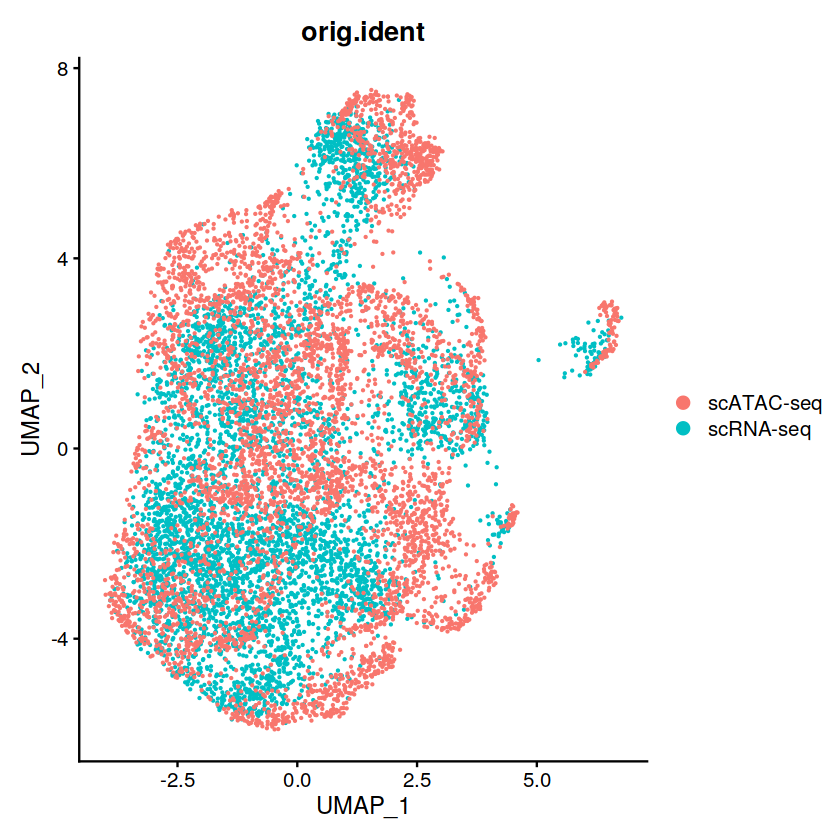

In [13]:
# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE, verbose = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30, verbose = FALSE)

DimPlot(coembed, group.by = c("orig.ident"))

In [15]:
seurat_embeddings <- Embeddings(coembed, 'pca')
seurat_embeddings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,⋯,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
Cell-1,-4.2768746,0.5676534,-2.35367512,1.34958716,-0.6714595,-2.06306807,3.16867078,1.04663836,-0.7243365,-1.8755020,⋯,-0.723141397,-0.93153064,-1.51951997,0.0009370847,0.23750711,-1.02147749,1.46529837,1.685312816,-0.61677686,0.59709870
Cell-2,-3.7777523,-0.3706875,-1.17021227,1.44536929,2.1860661,0.24293168,1.65790503,4.00002445,1.4798796,4.4401703,⋯,1.413395793,1.62386476,-1.06280243,-0.2937924603,-1.27765462,-0.84762586,-0.28591766,-0.890177949,0.96956953,-0.54920318
Cell-3,1.1560311,1.4972077,-0.30781271,1.84130966,-1.2077626,2.12491781,1.61264285,0.77451081,-0.7503179,2.6038216,⋯,0.067434742,-0.40175960,-0.20410351,-0.2401090391,2.46050632,-0.57497502,-0.55113004,-0.403063380,-1.00109322,-0.56588727
Cell-4,-3.7510729,-1.1211751,0.94825838,-0.10999795,-1.2358423,-3.14506867,0.02015163,-0.60445182,1.7377423,0.2851944,⋯,-2.014156872,0.27410622,-0.67284293,-1.3226241935,-1.02278583,1.42377733,0.36935786,-0.933284763,-0.53867119,1.21028614
Cell-5,-2.5828612,2.3053006,-0.48956081,3.25887559,-0.6621755,-1.21826520,-3.36459421,1.68275674,-0.7779500,0.1689015,⋯,0.253198175,1.42497184,-0.85163421,0.0873869495,-0.30338473,0.11485741,3.04650967,1.983485049,0.66227682,-0.84662096
Cell-6,-6.3039339,-3.8112226,-0.09853533,-1.25402506,2.8698062,0.16433095,-1.13700536,-0.09198718,-0.3884818,2.1241052,⋯,0.502815639,0.25662576,0.26767906,-0.3003035116,0.60993402,0.09419177,1.80817794,-2.293642675,-2.96094350,-2.35624543
Cell-7,-7.1726524,-2.3741217,0.87939190,-1.64780245,1.5422583,1.36514199,4.06419980,2.69292932,2.8439910,0.3471106,⋯,0.389835056,1.00020664,-1.88861548,-0.7130718778,-0.21292704,3.45823607,0.94174360,0.736193033,0.25202625,0.26712558
Cell-8,0.5112860,-3.9418608,1.80984783,0.88185677,-1.7723704,2.28772916,3.03416910,0.20597519,6.8600512,-3.7262041,⋯,0.294032235,-1.18008397,0.79028878,1.1832193077,0.67749893,-0.18665283,-0.38594307,-1.125811899,-0.69993259,-2.00685810
Cell-9,-0.3257351,2.4524712,-1.13878645,2.47776428,1.3660706,-2.24491539,-0.74273382,-2.10502924,-0.6130805,3.9603092,⋯,1.055520742,-1.01078907,-1.51185340,1.1235619156,-0.01703941,2.00098682,1.43785732,-1.136902291,0.38009635,-1.97474733
Cell-10,-4.2470867,0.4138830,-6.77521132,-1.35020691,0.6994321,-1.99510656,-1.32054621,0.80580546,2.3815374,-0.2828315,⋯,0.260895892,-0.14513956,1.87046560,0.1652507415,2.52955324,-1.73017273,1.28331243,1.982014928,-0.17172541,0.54572935


In [16]:
library(data.table)
# data_to_write_out <- as.data.frame(as.matrix(coembed[['RNA']]))
data_to_write_out <- as.data.frame(as.matrix(seurat_embeddings[1:dim(counts.rna)[2],]))
fwrite(x = data_to_write_out, file = "/home/xcx/results/P0/7-Seurat/z_rna.csv")

data_to_write_out <- as.data.frame(as.matrix(seurat_embeddings[(dim(counts.rna)[2]+1):(dim(counts.rna)[2] + dim(counts.atac)[2]),]))
fwrite(x = data_to_write_out, file = "/home/xcx/results/P0/7-Seurat/z_atac.csv")